## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [72]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [74]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
daily_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,date,group,users_count,purchase,price
0,2021-01-02,A,2894,362,29720000
1,2021-01-02,B,2889,348,29920000
2,2021-01-03,A,6684,760,62640000
3,2021-01-03,B,6710,762,66540000
4,2021-01-04,A,6655,810,64970000


In [75]:
daily_data.tail()

,date,group,users_count,purchase,price
41,2021-01-22,B,6748,795,69350000
42,2021-01-23,A,6783,854,71480000
43,2021-01-23,B,6728,814,69620000
44,2021-01-24,A,3811,451,33700000
45,2021-01-24,B,3727,449,39280000


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [76]:
print ('количество посещений группы А:', daily_data[daily_data['group'] == 'A']['users_count'].sum())
print ('количество посещений группы B:', daily_data[daily_data['group'] == 'B']['users_count'].sum())
print ('количество покупок группы А:', daily_data[daily_data['group'] == 'A']['purchase'].sum())
print ('количество покупок группы B:', daily_data[daily_data['group'] == 'B']['purchase'].sum())
print ('сумма всех покупок группы А:', daily_data[daily_data['group'] == 'A']['price'].sum())
print ('сумма всех покупок группы B:', daily_data[daily_data['group'] == 'B']['price'].sum())

количество посещений группы А: 147202
количество посещений группы B: 147276
количество покупок группы А: 17723
количество покупок группы B: 17514
сумма всех покупок группы А: 1436260000
сумма всех покупок группы B: 1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [77]:
users_A=set(data[data['group'] == 'A']['user_id'])
users_B=set(data[data['group'] == 'B']['user_id'])
print('Количество пользователей, попавших в обе группы:', len(users_A.intersection(users_B)))

Количество пользователей, попавших в обе группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [78]:
user_intersection=users_A.intersection(users_B)
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

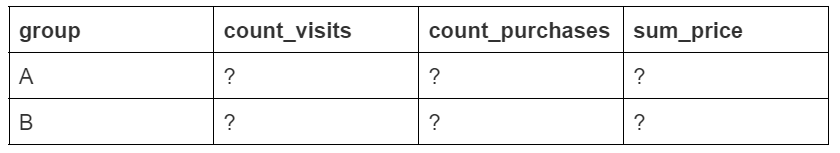
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [81]:
group_data = updated_data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 
                                 'purchase': 'count_purchases',
                                 'price': 'sum_price'})
display(group_data)

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Мы видим, что количество посещений в двух группах сопоставимо. данные получены за одинаковый период, так же мы исключили пользователей, которые попадали в обе группы, поэтому мы можем сравнивать конверсию и средний чек в этих группах и сделать выводы о том, какой вариант заглавной страницы лучше использовать и есть ли разница по результатам в каждой из групп.
Важно, чтобы группы были одинаковыми не только по количеству, но и по другим показателям пользователя, но у нас нет возможности сравнить группы по другим показателям пользователей, будем считать, что группы были равноценны при отборе.
Так же мы видим разницу в количестве покупок и сумме этих покупок для разных групп

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [83]:
group_data['conversion']=round(group_data['count_purchases']/group_data['count_visits']*100,2)
group_data['mean_check'] = round(group_data['sum_price']/group_data['count_purchases'],0)
display(group_data)

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсия по группе А выше, чем конверсия по группе В, но разница незначительная и надо проверить значимость такой эффективности.
По среднему чеку эффективность группы В выше, чем группы А, но так же необходимо проверить значимость этого показателя.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [84]:
pivot = updated_data.pivot_table(
    values='purchase',
    index='price',
    columns='group',
    aggfunc='count',
)
display(pivot)

group,A,B
price,,
0,127820,128091
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot:xlabel='group', ylabel='price'>

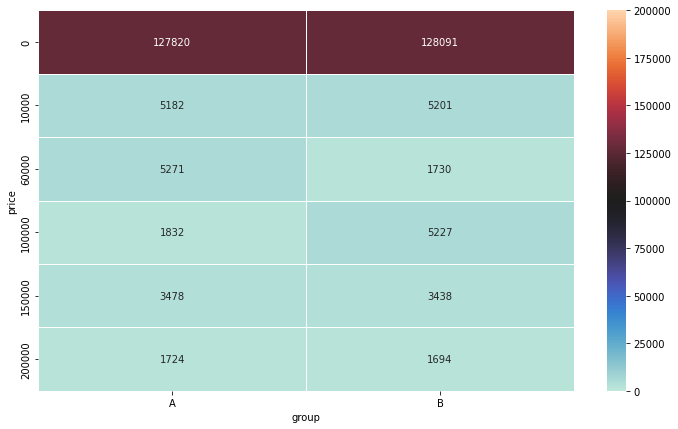

In [85]:
fig = plt.subplots(figsize=(12,7))
sns.heatmap(pivot, annot=True, vmin=0, vmax=200000, center=100000, linewidth=1, fmt='1g')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

в группе А покупательская способность выше для туров стоимостью 60 000 и 200 000. в остальных случаях покупательская способность в группе B выше. При этом сравнительно одинаковое количество человек в обеих группах не покупали туры вообще и количество визитов сайта без покупки гораздо выше, чем с покупкой туров.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [90]:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 
                                 'purchase': 'count_purchases',
                                 'price': 'sum_price'})
daily_data['conversion'] = daily_data['count_purchases']/daily_data['count_visits']*100
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']
display(daily_data[daily_data['date']=='2021-01-03'])

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [91]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивную сумму количества покупок
daily_data['cum_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_purchases']/daily_data['cum_visits'] * 100
# вычисляем кумулятивный средний чек
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_purchases']
display(daily_data.head())

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


In [92]:
display(daily_data[daily_data['date']=='2021-01-20'])
display(daily_data[daily_data['date']=='2021-01-12'])

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_sum_price,cum_conversion,cum_mean_check
36,2021-01-20,A,6533,749,58710000,11.464871,78384.512684,121506,14561,1179590000,11.983770,81010.232814
37,2021-01-20,B,6685,790,69250000,11.817502,87658.227848,121857,14496,1286900000,11.895911,88776.214128


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_sum_price,cum_conversion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.155963,86113.207547,68852,8198,668070000,11.906698,81491.827275
21,2021-01-12,B,6635,807,70560000,12.162773,87434.944238,69251,8236,727670000,11.892969,88352.355512


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

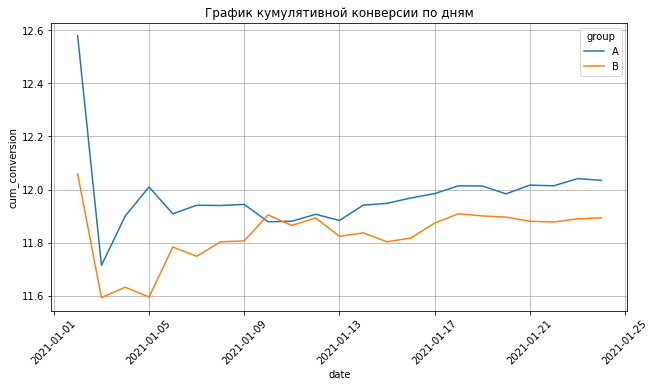

In [94]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

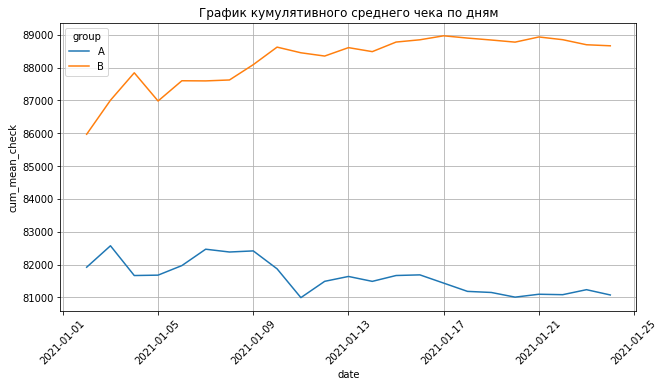

In [95]:
# создаём фигуру размером 8x4
fig2 = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig2.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

Мы видим, что данные стабилизировались и можно назвать тестирование завершенным. 
Данные по конверсии для группы А немного выше, чем для группы B, но разница небольшая, поэтому необходимо провести тест на значимость результатов.
При этом стоит отметить, что средний чек группы B выше, чем группы A в среднем на 4000, но так же необходимо провести тест на значимость результатов.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [97]:
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [98]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Для проверки статистической значимости для конверсии используется z-test для пропорции. 
При проверки значимости мы получили результат, что нельзя отвергнуть нулевую гипотезу, т е конверсия в группах А и В равны. Так как конверсия для обоих вариантов сайтов одинакова, то нет смысла внедрять изменения, количество покупок в обоих вариантах главной страницы будет одинаково. но при этом нужно проанализировать показатель среднего чека, возможно по нему есть значимая разница между группами, тогда следуюет использовать один из вариантов посадочной страницы.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [99]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)
conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group']=='A']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='A']['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group']=='B']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='B']['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [100]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)
# размеры выборок групп А и B
n = [updated_data[updated_data['group']=='A']['user_id'].count(), updated_data[updated_data['group']=='B']['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group']=='A']['purchase'].mean(), updated_data[updated_data['group']=='B']['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Мы видим, что доверительный интервал для конверсии в группе А пересекается с доверительным интервалом для конверсии группы В. 
Если же смотреть на доверительный интрвал для пропорции, то он включает 0, что означает, что нет разницы между конверсиями в этих группа.
аналогичный результат мы получили в рамках статистического теста, т е можем сделать вывод, что нет статистической разницы между конверсиями в двух группах, что подтверждает и статистический тест и доверительный интервал для конверсии.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [102]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data[daily_data['group']=='A']['mean_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group']=='B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Мы используем тест Шапиро-Уилка. так как у нас небольшое количество ежедневных наблюдений.
По результату теста мы принимаем нулевую гипотезу, что распределения в обеих группах нормальные.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [103]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и В равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе В'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data[daily_data['group']=='A']['mean_check'],
    b=daily_data[daily_data['group']=='B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и В равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе В


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Так как оба распределения у нас нормальные и количество дневных наблюдений менее 30, то можем использовать t-test.
По результатам теста p-value меньше, чем уровень значимости, следовательно мы отвергаем нулевую гипотезу, что средний чек в группах одинаковый. Поэтому можем сделать вывод, что средний чек в группе А ниже, чем в группе B. т е нет разницы в конверсии между вариантами сайта, но при этом есть разница в выручке.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [105]:
def conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return round(lower_bound, 2), round(upper_bound, 2)

conf_interval_a = conf_interval(
n=daily_data[daily_data['group']=='A']['mean_check'].count(), # размер выборки
x_mean=daily_data[daily_data['group']=='A']['mean_check'].mean(),
x_std=daily_data[daily_data['group']=='A']['mean_check'].std()  
)
conf_interval_b = conf_interval(
n=daily_data[daily_data['group']=='B']['mean_check'].count(), # размер выборки
x_mean=daily_data[daily_data['group']=='B']['mean_check'].mean(),
x_std=daily_data[daily_data['group']=='B']['mean_check'].std()  
)
print('Доверительный интервал для среднего чека группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для среднего чека группы B: {}'.format(conf_interval_b))

Доверительный интервал для среднего чека группы А: (79630.35, 82308.22)
Доверительный интервал для среднего чека группы B: (87625.83, 89525.61)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Мы видим, что доверительный интервал для среднего чего для группы А ниже, чем доверительный интервал для среднего чека для группы В, эти доверительные интервалы не пересекаются.
полученные доверительные интервалы подтверждают результат статистического теста, что средний чек для группы В выше, чем для группы А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

В результате A/B тестирования мы получили, что от смены дизайна посадочной страницы, конверсия по покупкам туристических пакетов не измененяется. При этом мы видим, что при использовании второго варианта посадочной страницы (группа В) средний чек по проданным турам вырастает. Поэтому имеет смысл использовать второй вариант посадочной страницы для увеличения выручки тур оператора.